In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from matplotlib.patches import Polygon
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Camera Calibration ###
def calibrate(images):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    objpoints = []
    imgpoints = []

    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

images = glob.glob('./camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = calibrate(images)

Text(0.5,1,'Undistorted Image')

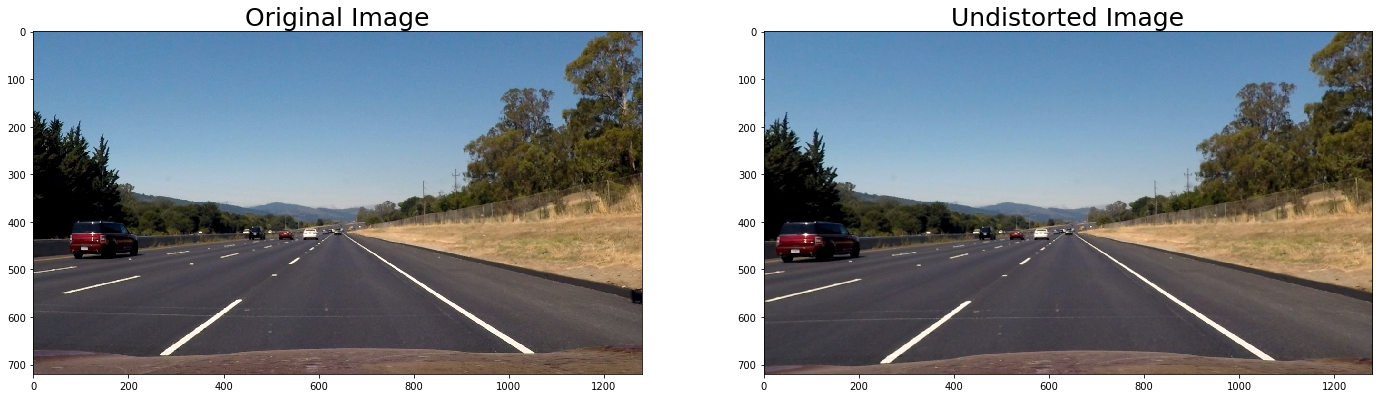

In [15]:
## Image Undistortion ###
img = mpimg.imread('./test_images/straight_lines2.jpg')
img_size = (img.shape[1], img.shape[0])

undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=25)

Text(0.5,1,'All Thresholds Combined')

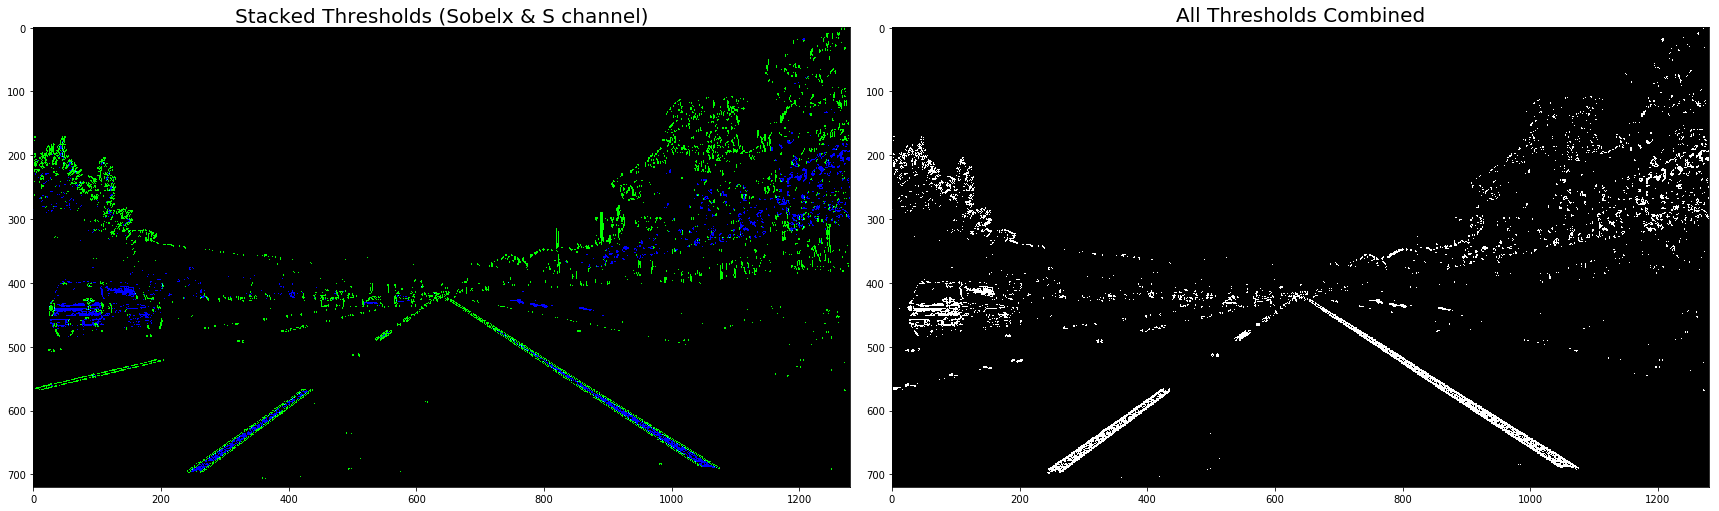

In [16]:
### Sobel Thresholding in X and Y directions ###
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

### Magnitude Thresholding ###
def mag_thresh(img, sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_xy = np.sqrt(sobelx**2 + sobely**2)
    scaled_mag = np.uint8(255*mag_xy/np.max(mag_xy))
    mag_binary = np.zeros_like(scaled_mag)
    mag_binary[(scaled_mag >= thresh[0]) & (scaled_mag <= thresh[1])] = 1
    
    return mag_binary

### Directional Thresholding ###
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(dir_gradient)
    dir_binary[(dir_gradient >= thresh[0]) & (dir_gradient <= thresh[1])] = 1
    
    return dir_binary

### HLS Color Space Thresholding ###
def color_thresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return s_binary

### Thresholding functions declarations ###
gradx_binary = abs_sobel_thresh(undistorted_img, orient='x', sobel_kernel=3, thresh=(30, 100))
grady_binary = abs_sobel_thresh(undistorted_img, orient='y', sobel_kernel=3, thresh=(20, 100))
mag_binary = mag_thresh(undistorted_img, sobel_kernel=7, thresh=(80, 250))
dir_binary = dir_thresh(undistorted_img, sobel_kernel=15, thresh=(0.7, 1.3))
s_binary= color_thresh(undistorted_img, thresh=(170, 245))
R = undistorted_img[:,:,0]
G = undistorted_img[:,:,1]
B = undistorted_img[:,:,2]

### Stacked Sobelx and S channel thresholds ###
stacked_sc = np.dstack((np.zeros_like(gradx_binary), gradx_binary, s_binary)) * 255

### Sobelx and S channel binary thresholds combined ###
combined_sc = np.zeros_like(gradx_binary)
combined_sc[(s_binary == 1) | (gradx_binary == 1)] = 1

### All thresholds combined ###
all_combined = np.zeros_like(gradx_binary)
all_combined[((gradx_binary==1) & (grady_binary==1)) | ((mag_binary==1) & (dir_binary==1)) | (s_binary==1)] = 1

### Plotting the results ###
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.imshow(stacked_sc)
ax1.set_title('Stacked Thresholds (Sobelx & S channel)', fontsize=20)
ax2.imshow(all_combined, cmap='gray')
ax2.set_title('All Thresholds Combined', fontsize=20)

Text(0.5,1,'Warped Image')

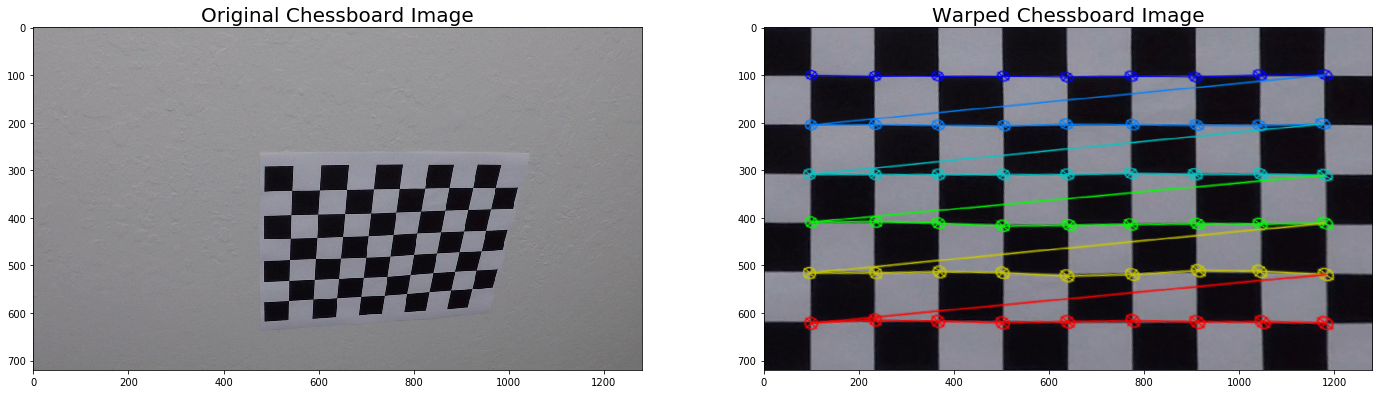

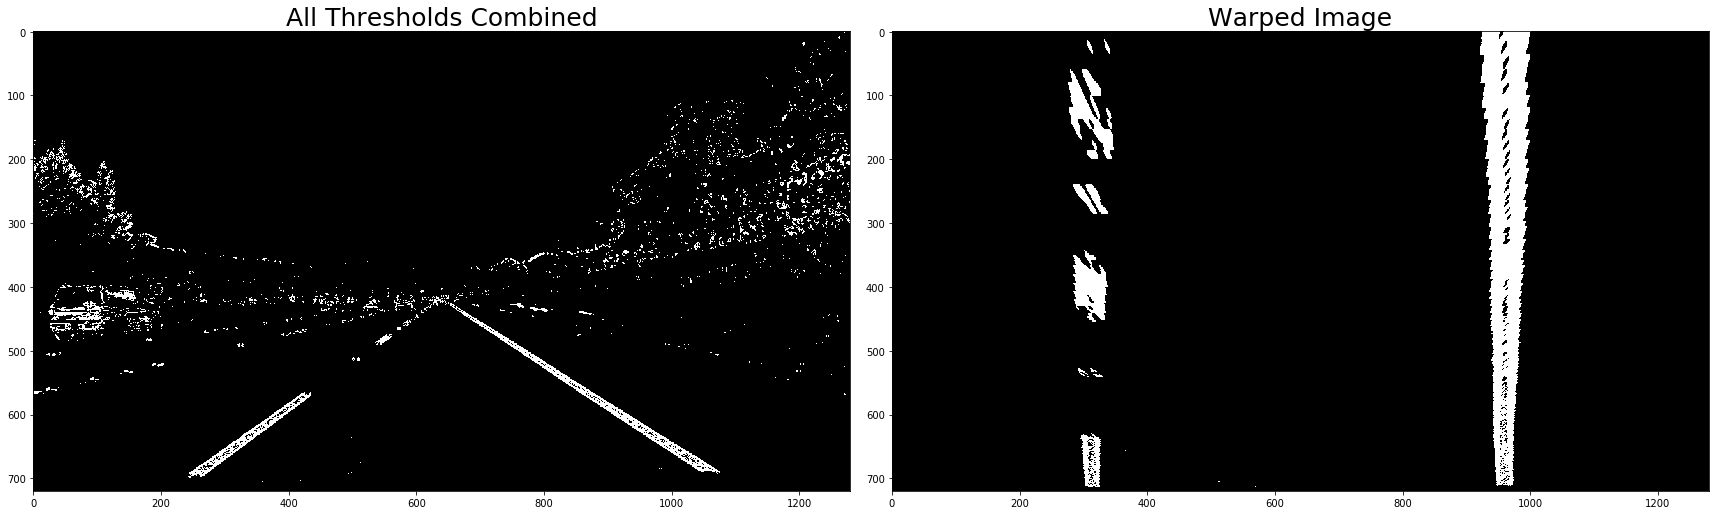

In [17]:
### Perspective Transform for chessboard images ###
def persp_transform_chess(chess_img, mtx, dist):
    chess_img_size = (chess_img.shape[1], chess_img.shape[0])
    undistorted_img = cv2.undistort(chess_img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        cv2.drawChessboardCorners(undistorted_img, (9,6), corners, ret)
        offset = 100
        src = np.float32([corners[0], corners[8], corners[-1], corners[-9]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset],
                         [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undistorted_img, M, chess_img_size, flags=cv2.INTER_LINEAR)
        
        return warped

chess_img = mpimg.imread('./camera_cal/calibration10.jpg')
warped_chessboard = persp_transform_chess(chess_img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
ax1.imshow(chess_img)
ax1.set_title('Original Chessboard Image', fontsize=20)
ax2.imshow(warped_chessboard)
ax2.set_title('Warped Chessboard Image', fontsize=20)
    
### Perspective Transform ###
def persp_transform(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[200, 720],
                      [593, 450],
                      [693, 450],
                      [1150, 720]])
    
    dst = np.float32([[300, 720],
                      [300, 0],
                      [990, 0],
                      [990, 720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv


warped, M, Minv = persp_transform(all_combined)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.imshow(all_combined, cmap='gray')
ax1.set_title('All Thresholds Combined', fontsize=25)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=25)

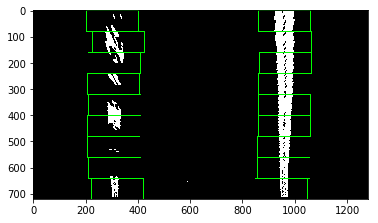

In [18]:
### Finding Lane Pixels using Sliding Windows ###
def find_lane_pixels(binary_warped, return_img=False):
    bottom_half = binary_warped[binary_warped.shape[0]//2:, :]
    histogram = np.sum(bottom_half, axis=0)
    
    # for the first frame
    if return_img:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    margin = 100
    min_pix = 50
    
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    nonzero = binary_warped.nonzero()  # nonzero pixels in the whole image
    nonzeroy = np.array(nonzero[0])    # nonzero y pixels
    nonzerox = np.array(nonzero[1])    # nonzero x pixels
    
    leftx_current = leftx_base         # this will change as the windows progress
    rightx_current = rightx_base       # this will change as the windows progress
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        
        win_leftx_low = leftx_current - margin
        win_leftx_high = leftx_current + margin
        win_rightx_low = rightx_current - margin
        win_rightx_high = rightx_current + margin
        
        if return_img:
            cv2.rectangle(out_img, (win_leftx_low, win_y_low), (win_leftx_high, win_y_high), (0,255,0), 2)
            cv2.rectangle(out_img, (win_rightx_low, win_y_low), (win_rightx_high, win_y_high), (0,255,0), 2)
        
        
        # good nonzero pixel positions within the window are recorded
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
                         & (nonzerox >= win_leftx_low) & (nonzerox < win_leftx_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
                          & (nonzerox >= win_rightx_low) & (nonzerox < win_rightx_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # adjust window if the number of good indices are more than the minimum pixel count
        if len(good_left_inds) > min_pix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > min_pix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    return leftx, lefty, rightx, righty, out_img

out_img = find_lane_pixels(warped, return_img=True)[4]
plt.imshow(out_img)

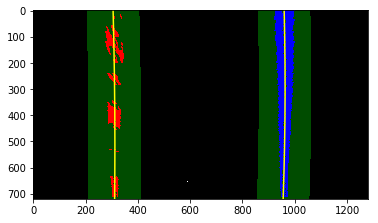

In [20]:
leftx, lefty, rightx, righty = find_lane_pixels(warped, return_img=True)[:4]
left_fit = np.polyfit(lefty, leftx, 2)      # left line coefficients
right_fit = np.polyfit(righty, rightx, 2)   # right line coefficients
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])

### drawing up the polynomial ###
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, leftx=None, rightx=None, return_img=False):
    if (leftx == None or rightx == None):
        return find_lane_pixels(binary_warped, return_img)
    
    margin = 100
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_poly = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
    right_poly = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    
    left_lane_inds = ((nonzerox > (left_poly - margin)) & (nonzerox <= (left_poly + margin)))
    right_lane_inds = ((nonzerox > (right_poly - margin)) & (nonzerox <= (right_poly + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
                       
    # if good pixels are not found, go back to finding the lane pixels from start
    if (leftx.size == 0 or rightx.size == 0):
        return find_lane_pixels(binary_warped, return_img)    
    
    if return_img:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

        # defining left line windows and points
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))

        # defining right line windows and points
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255,0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255,0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        # making left line pixels red and right blue
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255,0,0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0,0,255]

        # plotting the polynomials
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
                       
        return leftx, lefty, rightx, righty, out_img
    
    return leftx, lefty, rightx, righty
                    
out_img = search_around_poly(warped, leftx, rightx, return_img=True)[-1]
plt.imshow(out_img)

In [24]:
### Measuring Curvatures ###
def measure_curvature_pixels(left_fit, right_fit):
    ymax = warped.shape[0]
    
    left_curve_rad = ((1 + (2*left_fit[0]*ymax + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curve_rad = ((1 + (2*right_fit[0]*ymax + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        
    return left_curve_rad, right_curve_rad

left_curve_rad, right_curve_rad = measure_curvature_pixels(left_fit, right_fit)
print('Curvature Radius in Pixels:\n', 'Left Line:', left_curve_rad, '---', 'Right Line:', right_curve_rad)

ym_per_pix = 30/720
xm_per_pix = 3.7/700
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])

leftx, lefty, rightx, righty = find_lane_pixels(warped, return_img=True)[:4]
left_fit_real = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_real = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)

def measure_curvature_real(warped, left_fit_real, right_fit_real):
    ymax = np.max(warped.shape[0]*ym_per_pix)
    
    left_curve_rad = ((1 + (2*left_fit_real[0]*ymax + left_fit_real[1])**2)**1.5) / np.absolute(2*left_fit_real[0])
    right_curve_rad = ((1 + (2*right_fit_real[0]*ymax + right_fit_real[1])**2)**1.5) / np.absolute(2*right_fit_real[0])
    
    return left_curve_rad, right_curve_rad

left_curve_rad, right_curve_rad = measure_curvature_real(warped, left_fit_real, right_fit_real)
print('\nCurvature Radius in Meters:\n', 'Left Line:', left_curve_rad, '---', 'Right Line:', right_curve_rad, '\n')

curve_rad = (left_curve_rad + right_curve_rad) / 2

def vehicle_position(warped, left_fitx, right_fitx):
    left_x_pos = left_fitx[-1]*xm_per_pix
    right_x_pos = right_fitx[-1]*xm_per_pix
    lane_midpoint = (left_x_pos + right_x_pos) / 2
    image_center = (warped.shape[1]//2) * xm_per_pix
    
    offset = image_center - lane_midpoint
        
    return offset

offset = vehicle_position(warped, left_fitx, right_fitx)

if (offset > 0):
    print('Vehicle is ' + str(offset) + 'm right of center')
elif (offset < 0):
    print('Vehicle is ' + str(np.absolute(offset)) + 'm left of center')
else:
    print('Vehicle is centered')

Curvature Radius in Pixels:
 Left Line: 19520.1105681 --- Right Line: 12315.206211

Curvature Radius in Meters:
 Left Line: 6410.42429185 --- Right Line: 4037.79263129 

Vehicle is 0.0345701520841m right of center


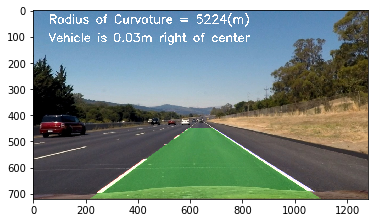

In [26]:
### Drawing ###
leftx, lefty, rightx, righty = find_lane_pixels(warped, return_img=True)[:4]
left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)

def draw_final_image(undistorted_image, warped_image, left_fitx, right_fitx, ploty):
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    margin = 100
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_poly = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
    right_poly = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    
    left_lane_inds = ((nonzerox > (left_poly - margin)) & (nonzerox <= (left_poly + margin)))
    right_lane_inds = ((nonzerox > (right_poly - margin)) & (nonzerox <= (right_poly + margin)))
    
    color_warp[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255,0,0]
    color_warp[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0,0,255]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    warped_inverse = cv2.warpPerspective(color_warp, Minv,
                    (undistorted_image.shape[1], undistorted_image.shape[0]))
    result = cv2.addWeighted(undistorted_image, 1, warped_inverse, 0.3, 0)
    
    return result

final_image = draw_final_image(undistorted_img, warped, left_fitx, right_fitx, ploty)

def text_overlay(final_image, curve_rad, offset):
    string1 = 'Radius of Curvature = %d(m)' % (curve_rad)
    
    if (offset > 0):
        string2 = "Vehicle is %.2fm right of center" % (offset)
    elif (offset < 0):
        string2 = 'Vehicle is %.2fm left of center' % (np.absolute(offset))
    else:
        string2 = 'Vehicle is centered'
    
    
    cv2.putText(final_image, string1, (60,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                              fontScale=1.5, color=(255,255,255), thickness=4)
    cv2.putText(final_image, string2, (60,120), fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                              fontScale=1.5, color=(255,255,255), thickness=4)
    
    return final_image

image_text = text_overlay(final_image, curve_rad, offset)
plt.imshow(image_text)

In [ ]:
# def process_pipeline(images):
    
#     images = glob.glob(images)
    
#     ret, mtx, dist, rvecs, tvecs = calibrate(images)
    
#     undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

#     ksize = 3
#     gradx_binary = abs_sobel_thresh(undistorted_img, orient='x', sobel_kernel=ksize, thresh=(30, 100))
    
#     s_binary= color_thresh(undistorted_img, thresh=(170, 255))
    
#     stacked_sc = np.dstack((np.zeros_like(gradx_binary), gradx_binary, s_binary)) * 255
#     combined_sc = np.zeros_like(gradx_binary)
#     combined_sc[(s_binary == 1) | (gradx_binary == 1)] = 1
    
#     warped, M, Minv = persp_transform(combined_sc)
    
#     leftx = None
#     rightx = None
    
#     leftx, lefty, rightx, righty = search_around_poly(warped, leftx, rightx, return_img=True)[:4]
# #     left_fit = np.polyfit(lefty, leftx, 2)
# #     right_fit = np.polyfit(righty, rightx, 2)
    
#     ym_per_pix = 30/720
#     xm_per_pix = 3.7/700
    
#     left_fit_real = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
#     right_fit_real = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
#     left_curve_rad, right_curve_rad = measure_curvature_real(left_fit_real, right_fit_real)
#     curve_rad = (left_curve_rad + right_curve_rad) / 2
    
#     left_fitx, right_fitx, ploty = fit_poly(warped.shape, leftx, lefty, rightx, righty)
    
#     offset = vehicle_position(left_fitx, right_fitx, xm_per_pix)
    
#     final_image = draw_final_image(undistorted_img, warped, left_fitx, right_fitx, ploty)

#     image_text = text_overlay(final_image, curve_rad, offset)
    
#     return image_text

# final = process_pipeline('./camera_cal/calibration*.jpg')
# plt.imshow(final)

In [9]:
class ProcessPipeline:
    def __init__(self, images):
        images = glob.glob(images)
        
        self.leftx = None
        self.rightx = None
        self.lefty = None
        self.righty = None
        
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate(images)
        
    def __call__(self, img):
        
        undistorted_img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        
        gradx_binary = abs_sobel_thresh(undistorted_img, orient='x', sobel_kernel=3, thresh=(30, 100))
        grady_binary = abs_sobel_thresh(undistorted_img, orient='y', sobel_kernel=3, thresh=(20, 100))
        mag_binary = mag_thresh(undistorted_img, sobel_kernel=7, thresh=(80, 250))
        dir_binary = dir_thresh(undistorted_img, sobel_kernel=15, thresh=(0.7, 1.3))
        s_binary = color_thresh(undistorted_img, thresh=(170, 245))
        
        all_combined = np.zeros_like(gradx_binary)
        all_combined[((gradx_binary==1) & (grady_binary==1)) | ((mag_binary==1) & (dir_binary==1)) | (s_binary==1)] = 1
    
        warped, M, Minv = persp_transform(all_combined)
        
        self.leftx, self.lefty, self.rightx, self.righty = search_around_poly(warped, self.leftx, 
                                                                              self.rightx, self.lefty, self.righty,
                                                                              return_img=True)[:4]

        ym_per_pix = 30/720
        xm_per_pix = 3.7/700

        left_fit_real = np.polyfit(self.lefty*ym_per_pix, self.leftx*xm_per_pix, 2)
        right_fit_real = np.polyfit(self.righty*ym_per_pix, self.rightx*xm_per_pix, 2)
        
        left_curve_rad, right_curve_rad = measure_curvature_real(warped, left_fit_real, right_fit_real, ym_per_pix)
        curve_rad = (left_curve_rad + right_curve_rad) / 2

        left_fitx, right_fitx, ploty = fit_poly(warped.shape, self.leftx, self.lefty, self.rightx, self.righty)

        offset = vehicle_position(warped, left_fitx, right_fitx, xm_per_pix)

        final_image = draw_final_image(undistorted_img, warped, self.leftx, self.lefty, self.rightx, self.righty,
                                       left_fitx, right_fitx, ploty, Minv)

        image_text = text_overlay(final_image, curve_rad, offset)

        return image_text

In [ ]:
video_output = 'project_video_output_test1_wclass.mp4'

clip1 = VideoFileClip('project_video.mp4').subclip(0,6)
process_pipeline = ProcessPipeline('./camera_cal/calibration*.jpg')
output_clip = clip1.fl_image(process_pipeline)
%time output_clip.write_videofile(video_output, audio=False)

In [ ]:
video_output = 'project_video_output_test2_wclass.mp4'

clip2 = VideoFileClip('project_video.mp4').subclip(19,25)
process_pipeline = ProcessPipeline('./camera_cal/calibration*.jpg')
output_clip = clip2.fl_image(process_pipeline)
%time output_clip.write_videofile(video_output, audio=False)

In [ ]:
video_output = 'project_video_output_test3_wclass.mp4'

clip3 = VideoFileClip('project_video.mp4').subclip(38,44)
process_pipeline = ProcessPipeline('./camera_cal/calibration*.jpg')
output_clip = clip3.fl_image(process_pipeline)
%time output_clip.write_videofile(video_output, audio=False)

In [ ]:
video_output_full = 'project_video_output_full.mp4'

clip4 = VideoFileClip('project_video.mp4')
process_pipeline = ProcessPipeline('./camera_cal/calibration*.jpg')
output_clip = clip4.fl_image(process_pipeline)
%time output_clip.write_videofile(video_output_full, audio=False)

In [ ]:
challenge_output = 'challenge_video_output.mp4'

clip5 = VideoFileClip('challenge_video.mp4')
process_pipeline = ProcessPipeline('./camera_cal/calibration*.jpg')
output_clip = clip5.fl_image(process_pipeline)
%time output_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [08:52<00:00,  2.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 4min 55s, sys: 1min 14s, total: 6min 9s
Wall time: 8min 57s


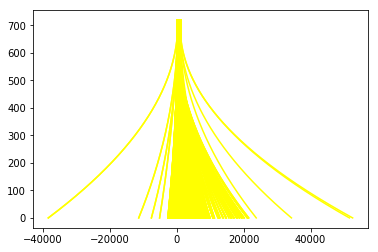

In [10]:
harder_challenge_output = 'harder_challenge_video_output.mp4'

clip6 = VideoFileClip('harder_challenge_video.mp4')
process_pipeline = ProcessPipeline('./camera_cal/calibration*.jpg')
output_clip = clip6.fl_image(process_pipeline)
%time output_clip.write_videofile(harder_challenge_output, audio=False)